In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 64.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


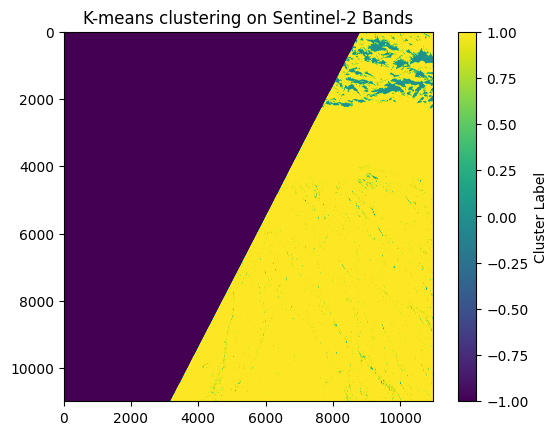

In [ ]:
import rasterio
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

base_path = "/content/drive/MyDrive/Week_4-20240130T090303Z-001/Week_4/S2A_MSIL1C_20190301T235611_N0207_R116_T01WCU_20190302T014622.SAFE/GRANULE/L1C_T01WCU_A019275_20190301T235610/IMG_DATA/" # You need to specify the path
bands_paths = {
    'B4': base_path + 'T01WCU_20190301T235611_B04.jp2',
    'B3': base_path + 'T01WCU_20190301T235611_B03.jp2',
    'B2': base_path + 'T01WCU_20190301T235611_B02.jp2',
}

# Read and stack the band images
band_data = []
for band in ['B4', 'B3', 'B2']:
    with rasterio.open(bands_paths[band]) as src:
        band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
band_stack = np.dstack(band_data)
valid_data_mask = np.all(band_stack > 0, axis=2)

# Reshape for K-means, only including valid data
X = band_stack[valid_data_mask].reshape((-1, 3))

# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
labels = kmeans.labels_

# Create an empty array for the result, filled with a no-data value (e.g., -1)
labels_image = np.full(band_stack.shape[:2], -1, dtype=int)

# Place cluster labels in the locations corresponding to valid data
labels_image[valid_data_mask] = labels

# Plotting the result
plt.imshow(labels_image, cmap='viridis')
plt.title('K-means clustering on Sentinel-2 Bands')
plt.colorbar(label='Cluster Label')
plt.show()


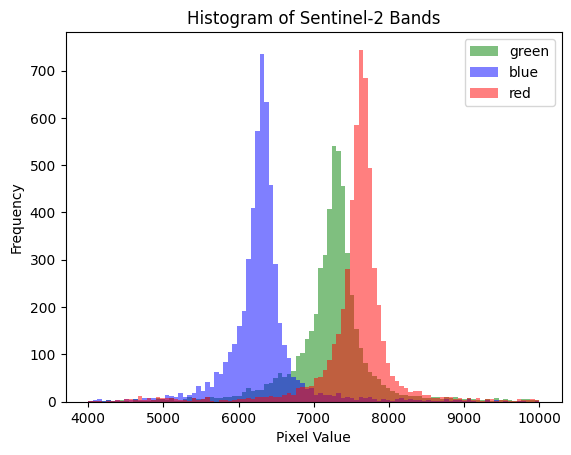

In [ ]:
import matplotlib.pyplot as plt

# Selecting a subset of the data for plotting
subset_data = band_stack[::100, ::100, :]

# Plotting histograms for each band
plt.hist(subset_data[:, :, 0].ravel(), bins=100, color='green', alpha=0.5, label='green', range=[4000, 10000])
plt.hist(subset_data[:, :, 1].ravel(), bins=100, color='blue', alpha=0.5, label='blue', range=[4000, 10000])
plt.hist(subset_data[:, :, 2].ravel(), bins=100, color='red', alpha=0.5, label='red', range=[4000, 10000])

plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram of Sentinel-2 Bands')
plt.legend()
plt.show()


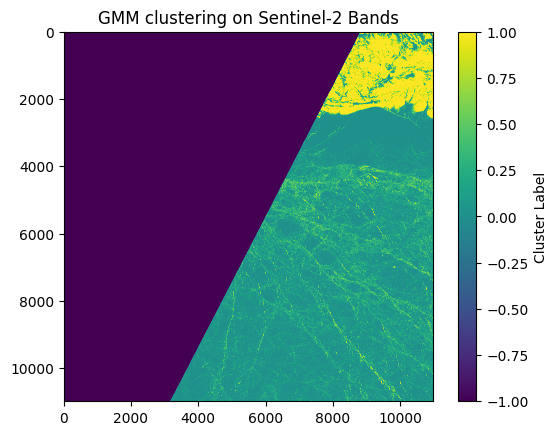

In [ ]:
import rasterio
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Paths to the band images
base_path = "/content/drive/MyDrive/Week_4-20240130T090303Z-001/Week_4/S2A_MSIL1C_20190301T235611_N0207_R116_T01WCU_20190302T014622.SAFE/GRANULE/L1C_T01WCU_A019275_20190301T235610/IMG_DATA/" # You need to specify the path
bands_paths = {
    'B4': base_path + 'T01WCU_20190301T235611_B04.jp2',
    'B3': base_path + 'T01WCU_20190301T235611_B03.jp2',
    'B2': base_path + 'T01WCU_20190301T235611_B02.jp2'
}

# Read and stack the band images
band_data = []
for band in ['B4', 'B3', 'B2']:
    with rasterio.open(bands_paths[band]) as src:
        band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
band_stack = np.dstack(band_data)
valid_data_mask = np.all(band_stack > 0, axis=2)

# Reshape for GMM, only including valid data
X = band_stack[valid_data_mask].reshape((-1, 3))

# GMM clustering
gmm = GaussianMixture(n_components=2, random_state=0).fit(X)
labels = gmm.predict(X)

# Create an empty array for the result, filled with a no-data value (e.g., -1)
labels_image = np.full(band_stack.shape[:2], -1, dtype=int)

# Place GMM labels in the locations corresponding to valid data
labels_image[valid_data_mask] = labels

# Plotting the result
plt.imshow(labels_image, cmap='viridis')
plt.title('GMM clustering on Sentinel-2 Bands')
plt.colorbar(label='Cluster Label')
plt.show()


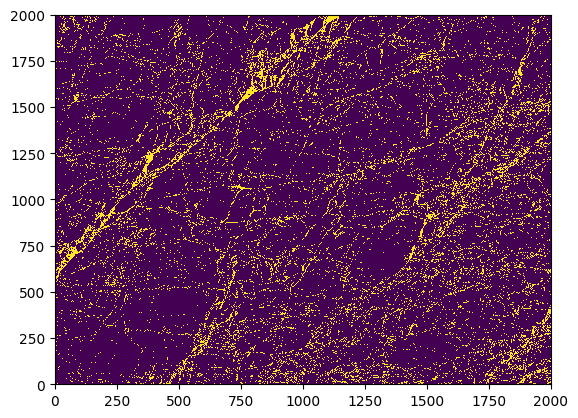

In [ ]:
plt.pcolor(labels_image[8000:10000,8000:10000])

In [10]:
! pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.5 MB/s eta 0:00:00


In [12]:
#
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
# from mpl_toolkits.basemap import Basemap
import numpy.ma as ma
import glob
from matplotlib.patches import Polygon
import scipy.spatial as spatial
from scipy.spatial import KDTree

import pyproj
# import cartopy.crs as ccrs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster

#=========================================================================================================
#===================================  SUBFUNCTIONS  ======================================================
#=========================================================================================================

#*args and **kwargs allow you to pass an unspecified number of arguments to a function,
#so when writing the function definition, you do not need to know how many arguments will be passed to your function
#**kwargs allows you to pass keyworded variable length of arguments to a function.
#You should use **kwargs if you want to handle named arguments in a function.
#double star allows us to pass through keyword arguments (and any number of them).
def peakiness(waves, **kwargs):

    "finds peakiness of waveforms."

    #print("Beginning peakiness")
    # Kwargs are:
    #          wf_plots. specify a number n: wf_plots=n, to show the first n waveform plots. \

    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import time

    print("Running peakiness function...")

    size=np.shape(waves)[0] #.shape property is a tuple of length .ndim containing the length of each dimensions
                            #Tuple of array dimensions.

    waves1=np.copy(waves)

    if waves1.ndim == 1: #number of array dimensions
        print('only one waveform in file')
        waves2=waves1.reshape(1,np.size(waves1)) #numpy.reshape(a, newshape, order='C'), a=array to be reshaped
        waves1=waves2

    # *args is used to send a non-keyworded variable length argument list to the function
    def by_row(waves, *args):
        "calculate peakiness for each waveform"
        maximum=np.nanmax(waves)
        if maximum > 0:

            maximum_bin=np.where(waves==maximum)
            #print(maximum_bin)
            maximum_bin=maximum_bin[0][0]
            waves_128=waves[maximum_bin-50:maximum_bin+78]

            waves=waves_128

            noise_floor=np.nanmean(waves[10:20])
            where_above_nf=np.where(waves > noise_floor)

            if np.shape(where_above_nf)[1] > 0:
                maximum=np.nanmax(waves[where_above_nf])
                total=np.sum(waves[where_above_nf])
                mean=np.nanmean(waves[where_above_nf])
                peaky=maximum/mean

            else:
                peaky = np.nan
                maximum = np.nan
                total = np.nan

        else:
            peaky = np.nan
            maximum = np.nan
            total = np.nan

        if 'maxs' in args:
            return maximum
        if 'totals' in args:
            return total
        if 'peaky' in args:
            return peaky

    peaky=np.apply_along_axis(by_row, 1, waves1, 'peaky') #numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)

    if 'wf_plots' in kwargs:
        maximums=np.apply_along_axis(by_row, 1, waves1, 'maxs')
        totals=np.apply_along_axis(by_row, 1, waves1, 'totals')

        for i in range(0,kwargs['wf_plots']):
            if i == 0:
                print("Plotting first "+str(kwargs['wf_plots'])+" waveforms")

            plt.plot(waves1[i,:])#, a, col[i],label=label[i])
            plt.axhline(maximums[i], color='green')
            plt.axvline(10, color='r')
            plt.axvline(19, color='r')
            plt.xlabel('Bin (of 256)')
            plt.ylabel('Power')
            plt.text(5,maximums[i],"maximum="+str(maximums[i]))
            plt.text(5,maximums[i]-2500,"total="+str(totals[i]))
            plt.text(5,maximums[i]-5000,"peakiness="+str(peaky[i]))
            plt.title('waveform '+str(i)+' of '+str(size)+'\n. Noise floor average taken between red lines.')
            plt.show()


    return peaky

#=========================================================================================================
#=========================================================================================================
#=========================================================================================================


def unpack_gpod(variable):

    from scipy.interpolate import interp1d

    time_1hz=SAR_data.variables['time_01'][:]
    time_20hz=SAR_data.variables['time_20_ku'][:]
    time_20hzC = SAR_data.variables['time_20_c'][:]

    out=(SAR_data.variables[variable][:]).astype(float)  # convert from integer array to float.

    #if ma.is_masked(dataset.variables[variable][:]) == True:
    #print(variable,'is masked. Removing mask and replacing masked values with nan')
    out=np.ma.filled(out, np.nan)

    if len(out)==len(time_1hz):

        print(variable,'is 1hz. Expanding to 20hz...')
        out = interp1d(time_1hz,out,fill_value="extrapolate")(time_20hz)

    if len(out)==len(time_20hzC):
        print(variable, 'is c band, expanding to 20hz ku band dimension')
        out = interp1d(time_20hzC,out,fill_value="extrapolate")(time_20hz)
    return out


#=========================================================================================================
#=========================================================================================================
#=========================================================================================================

def calculate_SSD(RIP):

    from scipy.optimize import curve_fit
    from scipy import asarray as ar,exp
    do_plot='Off'

    def gaussian(x,a,x0,sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

    SSD=np.zeros(np.shape(RIP)[0])*np.nan
    x=np.arange(np.shape(RIP)[1])

    for i in range(np.shape(RIP)[0]):

        y=np.copy(RIP[i])
        y[(np.isnan(y)==True)]=0

        if 'popt' in locals():
            del(popt,pcov)

        SSD_calc=0.5*(np.sum(y**2)*np.sum(y**2)/np.sum(y**4))
        #print('SSD calculated from equation',SSD)

        #n = len(x)
        mean_est = sum(x * y) / sum(y)
        sigma_est = np.sqrt(sum(y * (x - mean_est)**2) / sum(y))
        #print('est. mean',mean,'est. sigma',sigma_est)

        try:
            popt,pcov = curve_fit(gaussian, x, y, p0=[max(y), mean_est, sigma_est],maxfev=10000)
        except RuntimeError as e:
            print("Gaussian SSD curve-fit error: "+str(e))
            #plt.plot(y)
            #plt.show()

        except TypeError as t:
            print("Gaussian SSD curve-fit error: "+str(t))

        if do_plot=='ON':

            plt.plot(x,y)
            plt.plot(x,gaussian(x,*popt),'ro:',label='fit')
            plt.axvline(popt[1])
            plt.axvspan(popt[1]-popt[2], popt[1]+popt[2], alpha=0.15, color='Navy')
            plt.show()

            print('popt',popt)
            print('curve fit SSD',popt[2])

        if 'popt' in locals():
            SSD[i]=abs(popt[2])


    return SSD


In [32]:
pip install netCDF4 h5py


In [16]:
path = '/content/drive/MyDrive/Week_4-20240130T090303Z-001/Week_4/' # You need to specify the path
SAR_file='S3B_SR_2_LAN_SI_20190301T231304_20190301T233006_20230405T162425_1021_022_301______LN3_R_NT_005.SEN3'
print('overlapping SAR file is',SAR_file)
SAR_data=Dataset(path + SAR_file+'/enhanced_measurement.nc')

SAR_lat, SAR_lon, waves, sig_0, RIP, flag = unpack_gpod('lat_20_ku'), unpack_gpod('lon_20_ku'), unpack_gpod('waveform_20_ku'),unpack_gpod('sig0_water_20_ku'),unpack_gpod('rip_20_ku'),unpack_gpod('surf_type_class_20_ku') #unpack_gpod('Sigma0_20Hz')
SAR_index=np.arange(np.size(SAR_lat))

find=np.where(SAR_lat >= -99999)#60
SAR_lat=SAR_lat[find]
SAR_lon=SAR_lon[find]
SAR_index=SAR_index[find]
waves=waves[find]
sig_0=sig_0[find]
RIP=RIP[find]

PP=peakiness(waves)
SSD=calculate_SSD(RIP)
sig_0_np = np.array(sig_0)  # Replace [...] with your data
RIP_np = np.array(RIP)
PP_np = np.array(PP)
SSD_np = np.array(SSD)

data = np.column_stack((sig_0_np,PP_np, SSD_np))
# Standardize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

overlapping SAR file is S3B_SR_2_LAN_SI_20190301T231304_20190301T233006_20230405T162425_1021_022_301______LN3_R_NT_005.SEN3
Running peakiness function...


<ipython-input-12-aca971cfd1c5>:67: RuntimeWarning: Mean of empty slice
  noise_floor=np.nanmean(waves[10:20])


Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian SSD curve-fit error: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


In [33]:
flag_cleaned = flag[~np.isnan(data_normalized).any(axis=1)]
waves_cleaned=waves[~np.isnan(data_normalized).any(axis=1)][(flag_cleaned==1)|(flag_cleaned==2)]

In [34]:
nan_count = np.isnan(data_normalized).sum()
print(f"Number of NaN values in the array: {nan_count}")
data_cleaned = data_normalized[~np.isnan(data_normalized).any(axis=1)]
flag_cleaned = flag[~np.isnan(data_normalized).any(axis=1)]


Number of NaN values in the array: 387


In [35]:
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(data_cleaned[(flag_cleaned==1)|(flag_cleaned==2)])
clusters_gmm = gmm.predict(data_cleaned[(flag_cleaned==1)|(flag_cleaned==2)])

In [36]:

# Classify the clusters
leads_indices = np.where(clusters_gmm == 0)[0]
sea_ice_indices = np.where(clusters_gmm == 1)[0]

# Calculate average echo shapes and standard deviation for leads and sea ice
average_echo_shape_leads = np.mean(waves_cleaned[leads_indices], axis=0)
std_echo_shape_leads = np.std(waves_cleaned[leads_indices], axis=0)

average_echo_shape_sea_ice = np.mean(waves_cleaned[sea_ice_indices], axis=0)
std_echo_shape_sea_ice = np.std(waves_cleaned[sea_ice_indices], axis=0)

# Print class counts
unique, counts = np.unique(clusters_gmm, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Class Counts:", class_counts)

Class Counts: {0: 5013, 1: 1836}


In [37]:
# Classify the clusters
leads_data = waves_cleaned[clusters_gmm == 0]
sea_ice_data = waves_cleaned[clusters_gmm == 1]

# Calculate average echo shapes and standard deviation for leads and sea ice
average_echo_shape_leads = np.mean(leads_data, axis=0)
std_echo_shape_leads = np.std(leads_data, axis=0)

average_echo_shape_sea_ice = np.mean(sea_ice_data, axis=0)
std_echo_shape_sea_ice = np.std(sea_ice_data, axis=0)

# Print class counts and overview
print("Class Counts:")
print("Leads:", len(leads_data))
print("Sea Ice:", len(sea_ice_data))

# Print average echo shapes and standard deviation
print("\nAverage Echo Shape and Standard Deviation:")
print("Leads - Average Echo Shape:", average_echo_shape_leads)
print("Leads - Standard Deviation:", std_echo_shape_leads)
print("\nSea Ice - Average Echo Shape:", average_echo_shape_sea_ice)
print("Sea Ice - Standard Deviation:", std_echo_shape_sea_ice)


Class Counts:
Leads: 5013
Sea Ice: 1836

Average Echo Shape and Standard Deviation:
Leads - Average Echo Shape: [  3.81806822   3.4928861    3.29038999   2.9916136    2.86259366
   2.6602296    2.59014722   2.44965749   2.43405885   2.32642908
   2.27404249   2.20286754   2.17218472   2.1316916    2.12281329
   2.09777658   2.11741652   2.10602952   2.09073968   2.08770237
   2.08242988   2.07855416   2.14876122   2.11888749   2.13797147
   2.14436924   2.14683802   2.13354199   2.17319868   2.14995352
   2.19098863   2.19189946   2.20927788   2.21685278   2.24269858
   2.27494953   2.34482226   2.35986475   2.37756194   2.39174865
   2.46020606   2.50143287   2.54983742   2.64135607   2.76163415
   2.93527229   3.12708438   3.20208817   3.30320985   3.53019449
   3.72984221   3.76135727   3.87685278   4.14377518   4.50068582
   4.83270537   5.24408179   5.89055077   6.48583682   6.99017674
   7.65251247   8.5440002    9.8952326   11.78026551  14.30023978
  17.71554119  22.96194095  29

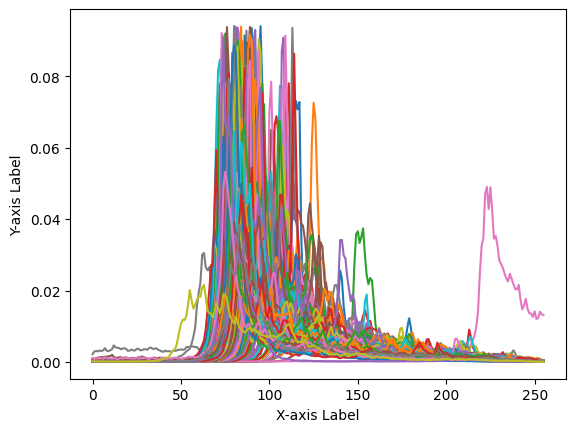

In [ ]:
# Extract the first 5 functions where clusters_gmm is equal to 0
functions_to_plot = waves[~np.isnan(data_normalized).any(axis=1)][(flag_cleaned==1)][::10]

# Plot each function
for i, function in enumerate(functions_to_plot):
    plt.plot(function/np.sum(function))#, label=f'Function {i+1}')

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
# plt.title('Plot of the first 5 functions where clusters_gmm is equal to 0')
# plt.legend()
plt.show()

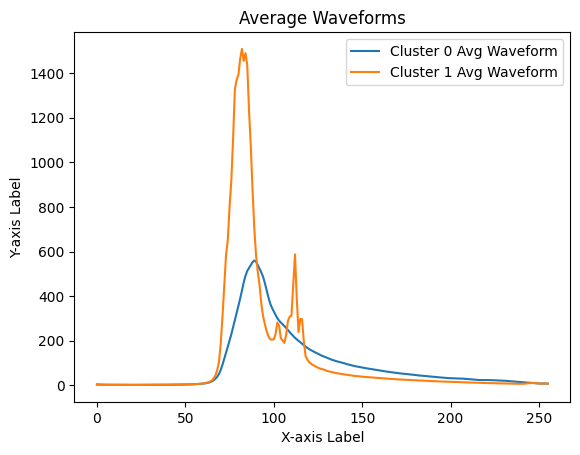

In [ ]:
# Calculate the average waveform for each cluster
avg_waveforms = []

for cluster in range(2):  # Assuming 2 clusters
    cluster_waveforms = waves_cleaned[clusters_gmm == cluster]
    avg_waveform = np.mean(cluster_waveforms, axis=0)
    avg_waveforms.append(avg_waveform)

# Plot the average waveform for each cluster
for cluster in range(2):  # Assuming 2 clusters
    plt.plot(avg_waveforms[cluster], label=f'Cluster {cluster} Avg Waveform')

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Average Waveforms')
plt.legend()
plt.show()


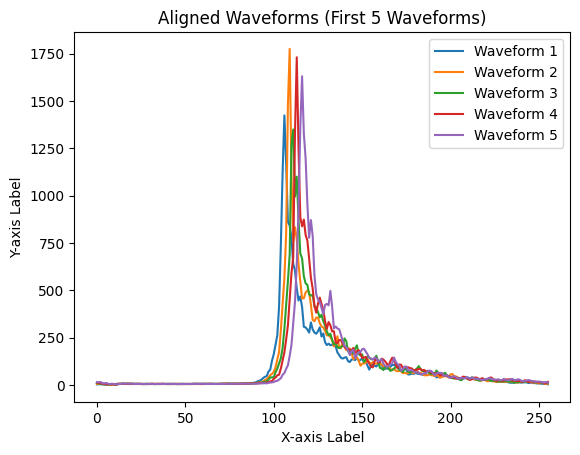

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Assuming waves_cleaned contains the waveforms
# Find peaks in each waveform
peaks = [find_peaks(waveform)[0] for waveform in waves_cleaned]

# Determine the leading edge width for each waveform
leading_edge_widths = [peak[0] for peak in peaks]

# Find the maximum leading edge width
max_leading_edge_width = max(leading_edge_widths)

# Shift each waveform to align their leading edges
aligned_waveforms = []
for waveform, peak in zip(waves_cleaned, peaks):
    shift_amount = max_leading_edge_width - peak[0]
    aligned_waveform = np.roll(waveform, shift_amount)
    aligned_waveforms.append(aligned_waveform)

# Limit the number of waveforms to plot
num_waveforms_to_plot = 5
for i, aligned_waveform in enumerate(aligned_waveforms[:num_waveforms_to_plot]):
    plt.plot(aligned_waveform, label=f'Waveform {i+1}')

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title(f'Aligned Waveforms (First {num_waveforms_to_plot} Waveforms)')
plt.legend()
plt.show()


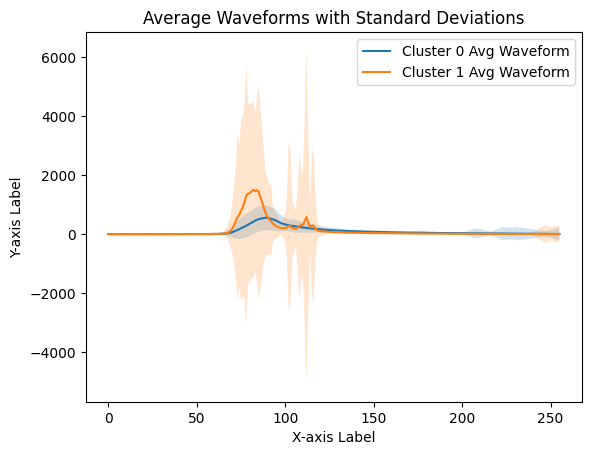

In [ ]:
# Calculate the average waveform and standard deviation for each cluster
avg_waveforms = []
std_devs = []

for cluster in range(2):  # Assuming 2 clusters
    cluster_waveforms = waves_cleaned[clusters_gmm == cluster]
    avg_waveform = np.mean(cluster_waveforms, axis=0)
    std_dev = np.std(cluster_waveforms, axis=0)
    avg_waveforms.append(avg_waveform)
    std_devs.append(std_dev)

# Plot the average waveform and standard deviation for each cluster
for cluster in range(2):  # Assuming 2 clusters
    plt.plot(avg_waveforms[cluster], label=f'Cluster {cluster} Avg Waveform')
    plt.fill_between(range(len(avg_waveforms[cluster])),
                     avg_waveforms[cluster] - std_devs[cluster],
                     avg_waveforms[cluster] + std_devs[cluster],
                     alpha=0.2)  # Fill between std deviations

plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Average Waveforms with Standard Deviations')
plt.legend()
plt.show()


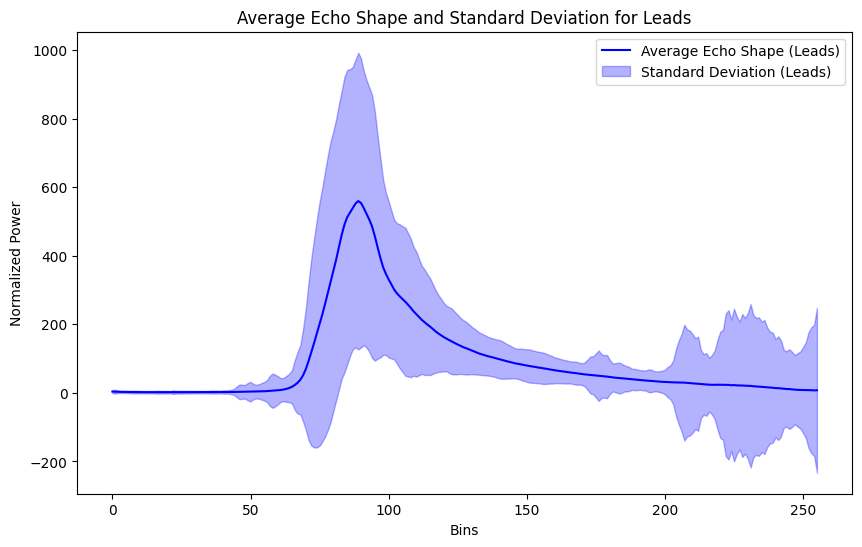

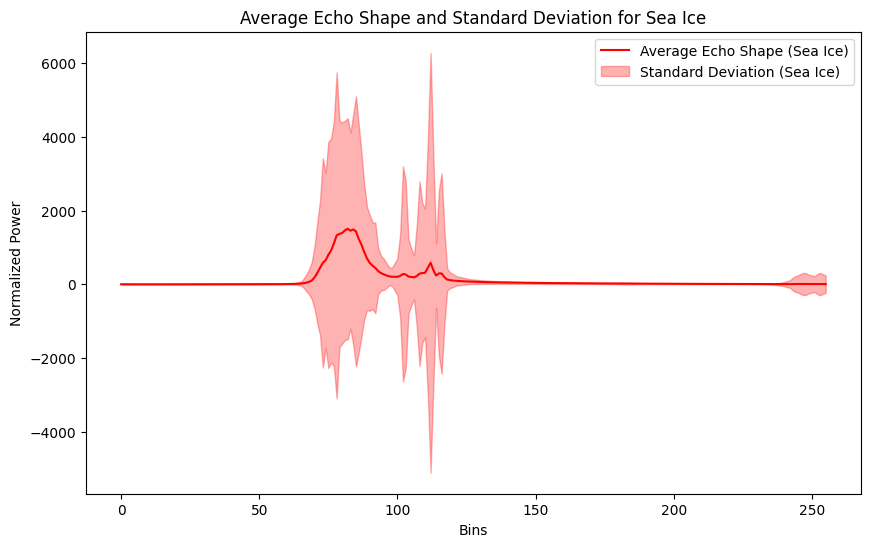

In [ ]:
import matplotlib.pyplot as plt

# Plot average echo shape and standard deviation for leads
plt.figure(figsize=(10, 6))
plt.plot(average_echo_shape_leads, label='Average Echo Shape (Leads)', color='blue')
plt.fill_between(range(len(average_echo_shape_leads)),
                 average_echo_shape_leads - std_echo_shape_leads,
                 average_echo_shape_leads + std_echo_shape_leads,
                 color='blue', alpha=0.3, label='Standard Deviation (Leads)')
plt.xlabel('Bins')
plt.ylabel('Normalized Power')
plt.title('Average Echo Shape and Standard Deviation for Leads')
plt.legend()
plt.show()

# Plot average echo shape and standard deviation for sea ice
plt.figure(figsize=(10, 6))
plt.plot(average_echo_shape_sea_ice, label='Average Echo Shape (Sea Ice)', color='red')
plt.fill_between(range(len(average_echo_shape_sea_ice)),
                 average_echo_shape_sea_ice - std_echo_shape_sea_ice,
                 average_echo_shape_sea_ice + std_echo_shape_sea_ice,
                 color='red', alpha=0.3, label='Standard Deviation (Sea Ice)')
plt.xlabel('Bins')
plt.ylabel('Normalized Power')
plt.title('Average Echo Shape and Standard Deviation for Sea Ice')
plt.legend()
plt.show()


In [39]:
from sklearn.metrics import confusion_matrix


# Determine the minimum number of samples between ground truth and predicted labels
min_samples = min(len(flag_cleaned), len(clusters_gmm))

# Trim both arrays to have the same number of samples
flag_cleaned_aligned = flag_cleaned[:min_samples]
clusters_gmm_aligned = clusters_gmm[:min_samples]

# Compute confusion matrix
conf_matrix = confusion_matrix(flag_cleaned_aligned, clusters_gmm_aligned)

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[ 795  185    0    0]
 [2557 1133    0    0]
 [ 431  134    0    0]
 [1230  384    0    0]]


In [42]:
pip install matplotlib seaborn


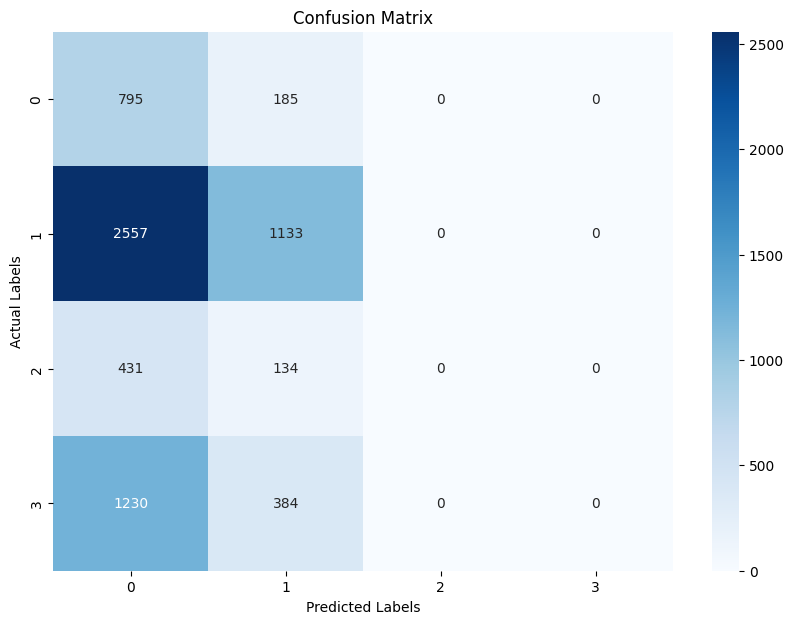

In [43]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have ground truth labels in flag_cleaned and predicted labels in clusters_gmm

# Determine the minimum number of samples between ground truth and predicted labels
min_samples = min(len(flag_cleaned), len(clusters_gmm))

# Trim both arrays to have the same number of samples
flag_cleaned_aligned = flag_cleaned[:min_samples]
clusters_gmm_aligned = clusters_gmm[:min_samples]

# Compute confusion matrix
conf_matrix = confusion_matrix(flag_cleaned_aligned, clusters_gmm_aligned)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image and store it in images_classified dictionary
image_path = "/content/drive/MyDrive/Week_4-20240130T090303Z-001/Week_4/labels_image.png"
images_classified = {'/content/drive/MyDrive/Week_4-20240130T090303Z-001/Week_4/labels_image.png': mpimg.imread(image_path)}

# Access the array values
array_values = images_classified['/content/drive/MyDrive/Week_4-20240130T090303Z-001/Week_4/labels_image.png']

# Now you can access the array values
print(array_values)


[[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 ...

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]


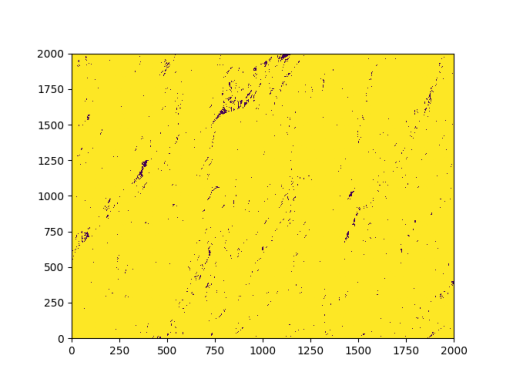

In [22]:
import matplotlib.pyplot as plt

# Display the image
plt.imshow(array_values, cmap='gray')
plt.axis('off')  # Remove axis
plt.show()
